In [2]:
import pandas as pd

df_opensearch = pd.read_csv('response_stats_opensearch.csv')
df_opensearch["database"] = "opensearch"
df_postgres = pd.read_csv('response_stats_postgres.csv')
df_postgres["database"] = "postgres"
df_sqlserver = pd.read_csv('response_stats_sqlserver.csv')
df_sqlserver["database"] = "sqlserver"

df = pd.concat([df_opensearch, df_postgres, df_sqlserver], ignore_index=True)
df = df.rename(columns={"response_time": "response_time_ms"})
df.head()

,from_offset,size,response_time_ms,database
0,10000,1,0.067552,opensearch
1,100000,1,0.052094,opensearch
2,1000000,1,0.053030,opensearch
3,10000,25,0.064249,opensearch
4,100000,25,0.057910,opensearch


In [3]:
grouped = df.groupby(by=["database", "from_offset", "size"])
grouped.agg(
    {
        "response_time_ms": ["mean", "std"],
    }
)

response_time_ms          
                                        mean       std
database   from_offset size                           
opensearch 10000       1            0.057156  0.005179
                       25           0.056929  0.004729
                       500          0.056804  0.005467
           100000      1            0.057202  0.005330
                       25           0.057151  0.006484
                       500          0.056939  0.005195
           1000000     1            0.056466  0.005379
                       25           0.056754  0.008011
                       500          0.056466  0.006182
postgres   10000       1            0.002713  0.000997
                       25           0.002850  0.001265
                       500          0.003604  0.002439
           100000      1            0.012560  0.004475
                       25           0.013672  0.006942
                       500          0.014109  0.006644
           1000000     1            0.112219  0.037692
                       25           0.118744  0.046321
                       500          0.107530  0.033612
sqlserver  10000       1            0.004769  0.001767
                       25           0.005341  0.002350
                       500          0.006379  0.002869
           100000      1            0.019901  0.007996
                       25           0.020216  0.008889
                       500          0.020653  0.008275
           1000000     1            0.153120  0.049029
                       25           0.160378  0.050593
                       500          0.156762  0.046077

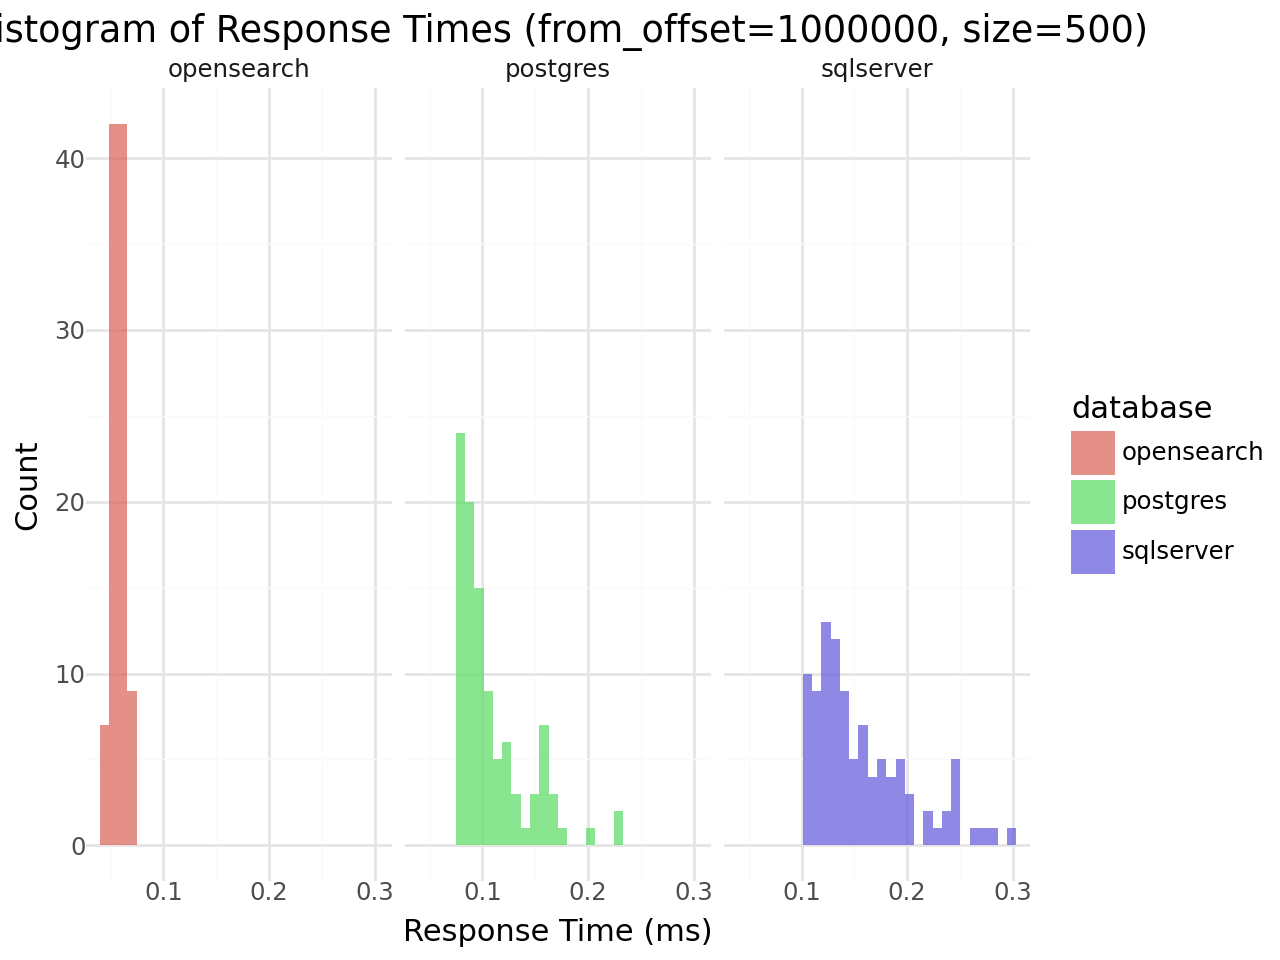

In [4]:
from plotnine import ggplot, aes, geom_histogram, labs, theme_minimal, facet_wrap

# Filter the dataframe for the specified conditions
filtered_df = df[(df['from_offset'] == 1000000) & (df['size'] == 500)]

# Create the histogram plot
(
  ggplot(filtered_df, aes(x='response_time_ms', fill='database'))
  + geom_histogram(alpha=0.7, bins=30, position='identity')
  + facet_wrap('~database')
  + labs(
    title='Histogram of Response Times (from_offset=1000000, size=500)',
    x='Response Time (ms)',
    y='Count'
  )
  + theme_minimal()
)

In [5]:
df_opensearch2 = pd.read_csv('docker_stats_opensearch.txt', sep='\s+')
df_opensearch2["database"] = "opensearch"
df_postgres2 = pd.read_csv('docker_stats_postgres.txt', sep='\s+')
df_postgres2["database"] = "postgres"
df_sqlserver2 = pd.read_csv('docker_stats_sqlserver.txt', sep='\s+')
df_sqlserver2["database"] = "sqlserver"

df_docker = pd.concat([df_opensearch2, df_postgres2, df_sqlserver2], ignore_index=True)

# Rename the columns
df_docker = df_docker.rename(columns={"CONTAINER": "Container ID", "ID": "Container Name", "NAME": "CPU2", "CPU": "Memory"})
df_docker = df_docker.rename(columns={"CPU2": "CPU"})
df_docker.drop(columns=["%"], inplace=True)

df_docker["CPU"] = df_docker["CPU"].str.replace("%", "").astype(float)

def convert_memory(memory_str):
    if "MiB" in memory_str:
        return float(memory_str.replace("MiB", "").strip())
    elif "GiB" in memory_str:
        return float(memory_str.replace("GiB", "").strip()) * 1024
    else:
        return float(memory_str.strip())
    
df_docker["Memory"] = df_docker["Memory"].apply(convert_memory)

df_docker.head()

,Container ID,Container Name,CPU,Memory,MEM,USAGE,/,LIMIT,MEM.1,%.1,NET,I/O,BLOCK,I/O.1,PIDS,database
0,b53769ddda32,opensearch,2.06,1414.144,15.41GiB,8.96%,84.2MB,/,374MB,0B,/,0B,155,NaN,NaN,opensearch
1,b53769ddda32,opensearch,1.08,1423.360,15.41GiB,9.02%,84.6MB,/,374MB,0B,/,0B,157,NaN,NaN,opensearch
2,b53769ddda32,opensearch,1.48,1423.360,15.41GiB,9.02%,84.6MB,/,374MB,0B,/,0B,157,NaN,NaN,opensearch
3,b53769ddda32,opensearch,1.23,1423.360,15.41GiB,9.02%,84.6MB,/,374MB,0B,/,0B,156,NaN,NaN,opensearch
4,b53769ddda32,opensearch,1.19,1423.360,15.41GiB,9.02%,84.6MB,/,374MB,0B,/,0B,156,NaN,NaN,opensearch


In [6]:
df_docker.groupby(by=["database"]).agg(
    {
        "Memory": ["mean", "std"],
        "CPU": ["mean", "std"],
    }
)

Memory                 CPU          
                   mean       std      mean       std
database                                             
opensearch  1424.769267  1.395434  1.139109  0.339512
postgres     111.223762  0.173291  0.079604  0.255456
sqlserver   1287.360634  0.402182  2.412079  0.907801

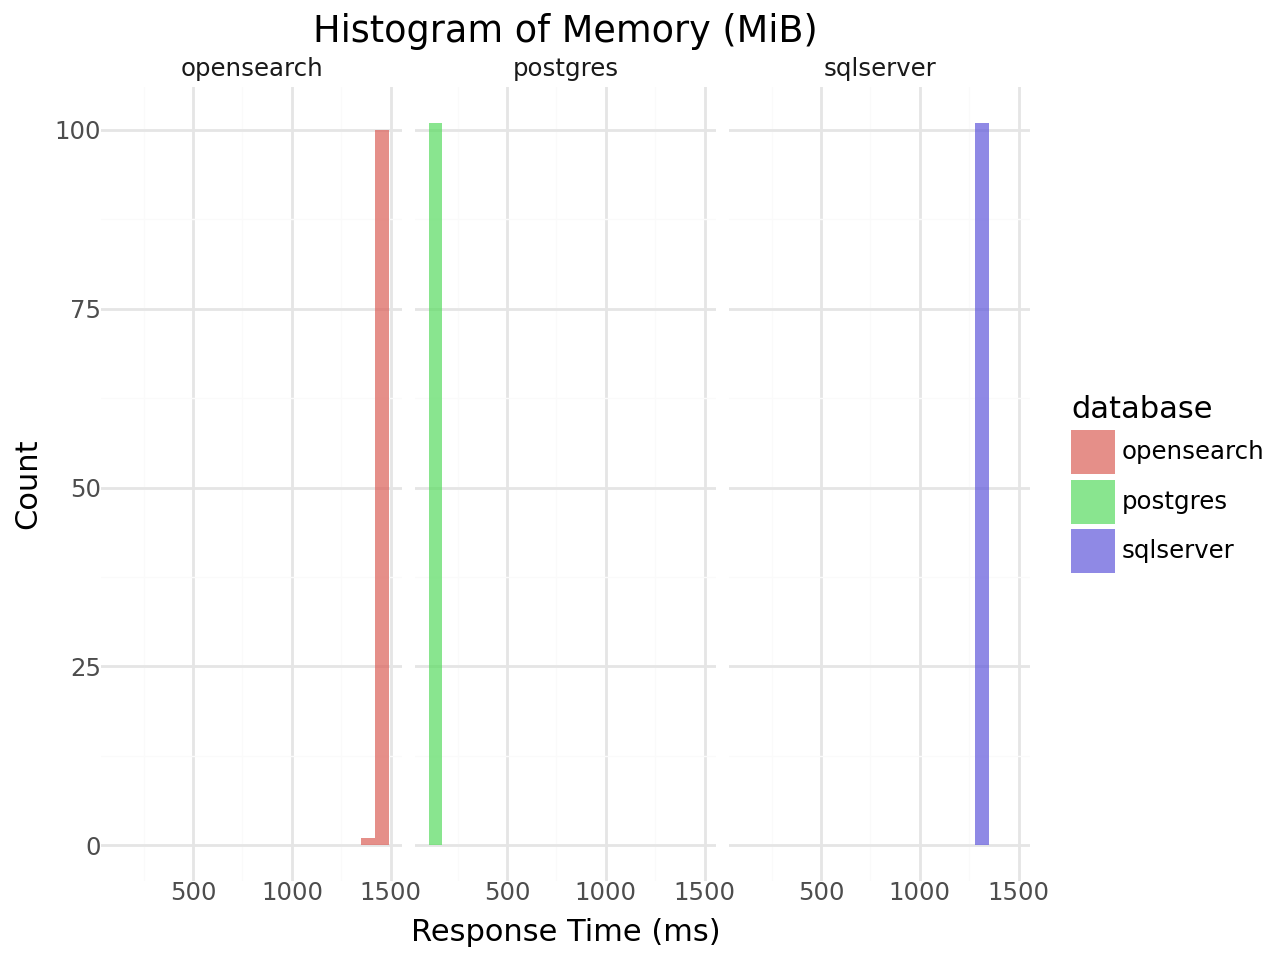

In [14]:
(
  ggplot(df_docker, aes(x='Memory', fill='database'))
  + geom_histogram(alpha=0.7, bins=20, position='identity')
  + facet_wrap('~database')
  + labs(
    title='Histogram of Memory (MiB)',
    x='Response Time (ms)',
    y='Count'
  )
  + theme_minimal()
)

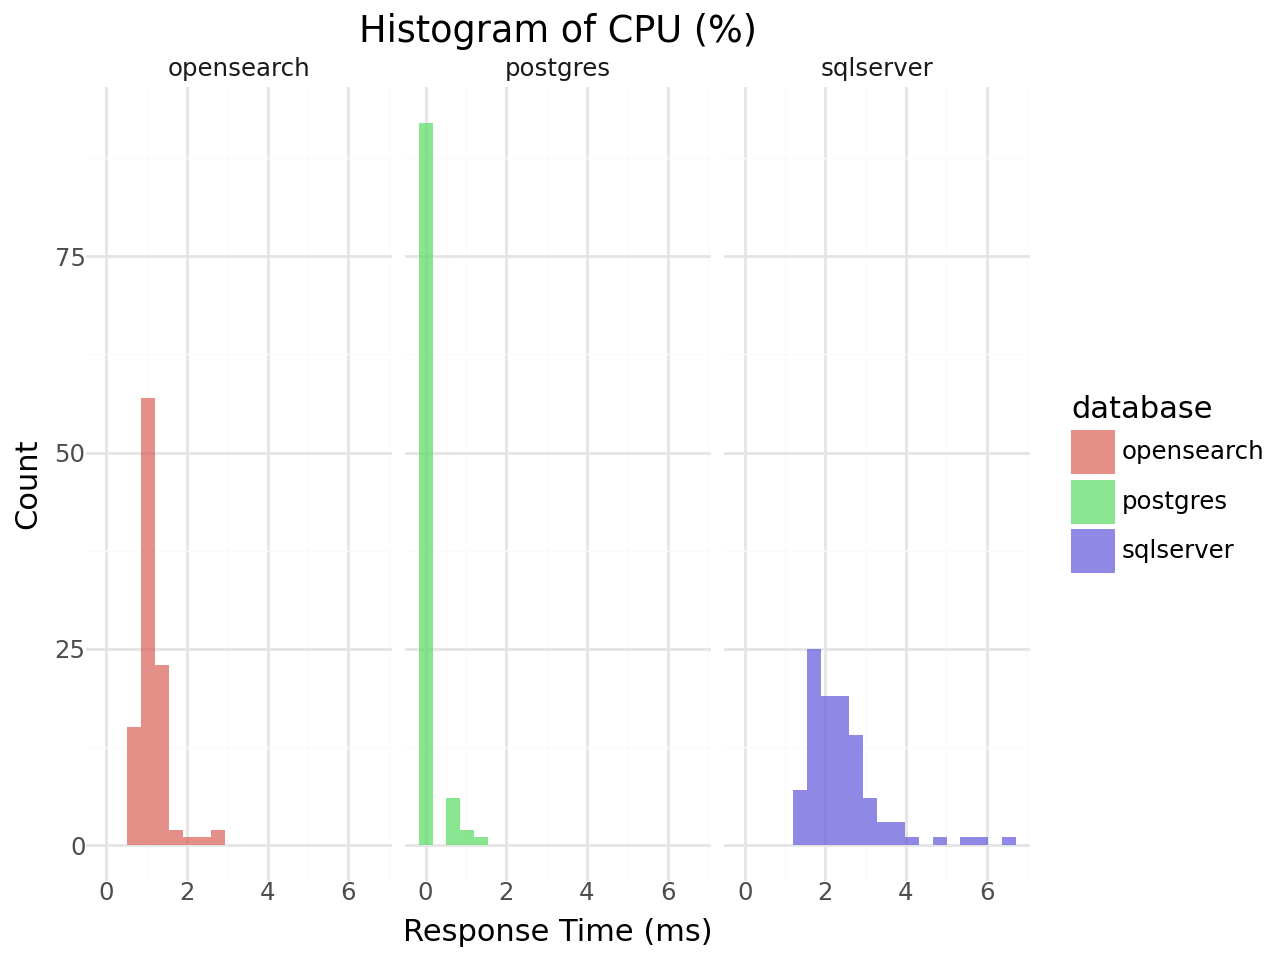

In [15]:
(
  ggplot(df_docker, aes(x='CPU', fill='database'))
  + geom_histogram(alpha=0.7, bins=20, position='identity')
  + facet_wrap('~database')
  + labs(
    title='Histogram of CPU (%)',
    x='Response Time (ms)',
    y='Count'
  )
  + theme_minimal()
)